In [1]:
import riskfolio as rp
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
assets = ["ALI=F", "HG=F", "ZN=F", "GC=F", "SI=F"]
train = yf.download(assets, start="2019-08-01", end="2022-08-01", interval="1wk")
test = yf.download(assets, start="2022-08-01", end="2023-02-25", interval="1wk")
train = train["Adj Close"]
test = test["Adj Close"]

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


In [3]:
train_returns = train.pct_change().dropna()
neg_returns = train_returns.apply(lambda x: x*-1)
neg_returns.columns = ['mALI=F', 'mGC=F', 'mHG=F', 'mSI=F', 'mZN=F']
neg_returns.head()

,mALI=F,mGC=F,mHG=F,mSI=F,mZN=F
Date,,,,,
2019-08-05,-0.005184,-0.035279,-0.007407,-0.041610,-0.006427
2019-08-12,-0.008279,-0.010624,-0.002322,-0.011777,-0.009518
2019-08-19,0.018037,-0.009322,0.024710,-0.017489,-0.000239
2019-08-26,0.036052,0.004913,-0.002771,-0.045415,-0.000716
2019-09-02,-0.017491,0.008492,-0.032570,0.011933,0.002385


In [4]:
train_df = pd.concat([train_returns, neg_returns], axis=1)
train_df = train_df[['mALI=F','GC=F','HG=F','mSI=F','ZN=F']]
train_df.head()

,mALI=F,GC=F,HG=F,mSI=F,ZN=F
Date,,,,,
2019-08-05,-0.005184,0.035279,0.007407,-0.041610,0.006427
2019-08-12,-0.008279,0.010624,0.002322,-0.011777,0.009518
2019-08-19,0.018037,0.009322,-0.024710,-0.017489,0.000239
2019-08-26,0.036052,-0.004913,0.002771,-0.045415,0.000716
2019-09-02,-0.017491,-0.008492,0.032570,0.011933,-0.002385


## Model Implementation (CVaR)

In [5]:
method_mu = "hist"
method_cov = "hist"
model = "Classic"
rm="CVaR"
obj = "Sharpe"
rf = 0
l = 0
hist=True

In [6]:
port = rp.Portfolio(returns=train_df)
port.assets_stats(method_mu=method_mu, method_cov=method_cov)
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
weights = w.T

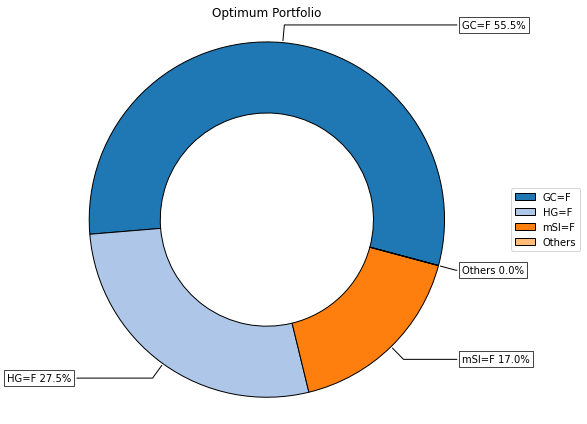

In [7]:
ax = rp.plot_pie(w=w, title="Optimum Portfolio", others=0.01, cmap="tab20")
plt.show()

<AxesSubplot:title={'center':'Portfolio Weights'}>

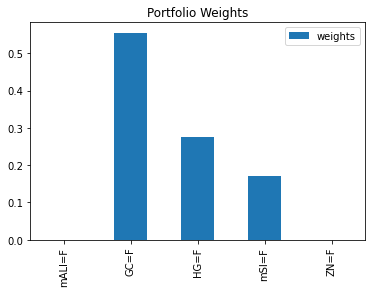

In [8]:
w.plot(kind="bar",title="Portfolio Weights")

In [9]:
test_neg = test.apply(lambda x: x*-1)
test_neg.columns = ['mALI=F','mGC=F','mHG=F','mSI=F','mZN=F']
test_df = pd.concat([test, test_neg], axis=1)
test_df.head()

,ALI=F,GC=F,HG=F,SI=F,ZN=F,mALI=F,mGC=F,mHG=F,mSI=F,mZN=F
Date,,,,,,,,,,
2022-08-01,2396.75,1772.900024,3.5530,19.819000,119.375000,-2396.75,-1772.900024,-3.5530,-19.819000,-119.375000
2022-08-08,2421.75,1798.599976,3.6760,20.677000,119.265625,-2421.75,-1798.599976,-3.6760,-20.677000,-119.265625
2022-08-15,2371.75,1747.599976,3.6835,19.058001,118.109375,-2371.75,-1747.599976,-3.6835,-19.058001,-118.109375
2022-08-22,2484.00,1736.099976,3.7115,18.740000,117.578125,-2484.00,-1736.099976,-3.7115,-18.740000,-117.578125
2022-08-29,2276.50,1709.800049,3.4215,17.775999,116.656250,-2276.50,-1709.800049,-3.4215,-17.775999,-116.656250


In [10]:
test_portfolio = test_df[['GC=F','HG=F','SI=F']]
test_portfolio.head()

,GC=F,HG=F,SI=F
Date,,,
2022-08-01,1772.900024,3.5530,19.819000
2022-08-08,1798.599976,3.6760,20.677000
2022-08-15,1747.599976,3.6835,19.058001
2022-08-22,1736.099976,3.7115,18.740000
2022-08-29,1709.800049,3.4215,17.775999


In [11]:
def returns(test_df):
    portfolio_returns = []
    cols = list(test_df.columns)
    cols[2] = "mSI=F"
    port_weights = np.array(weights[cols])[0]
    for i in range(len(test_portfolio)):
        weekly_returns = np.array(((test_portfolio.iloc[i,:])-(test_portfolio.iloc[0,:])) / (test_portfolio.iloc[0,:]))
        weekly_returns[2] *= -1
        cum_returns = np.dot(weekly_returns,port_weights.T)
        portfolio_returns.append(cum_returns)
    return portfolio_returns

In [12]:
port_returns = returns(test_portfolio)

Text(0, 0.5, 'Percentage Return Rate')

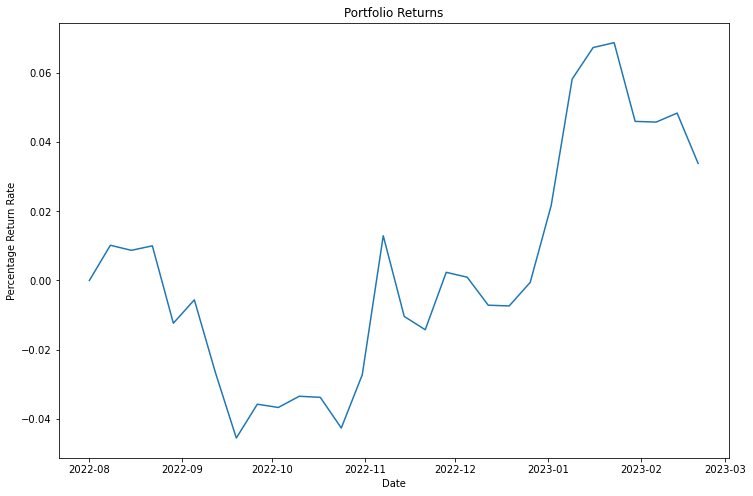

In [13]:
plt.figure(figsize=(12,8))
sns.lineplot(x=list(test_portfolio.index),y=port_returns)
plt.title('Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Percentage Return Rate')